In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl

from ablang_train import ABtokenizer, AbLang, TrainingFrame, CallbackHandler, AbDataModule, ablang_parse_args

/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
arguments = ablang_parse_args(args=["--json_args", "../reports/model_arguments/unpaired_heavy.json"], is_test=True)

In [3]:
arguments.model_specific_args

Namespace(name='unpaired_heavy', json_args='../reports/model_arguments/unpaired_heavy.json', n_encoder_blocks=6, hidden_embed_size=320, n_attn_heads=20, dropout=0.1, use_tkn_dropout=False, loss_fn='CrossEntropy_Loss', a_fn='gelu', fl_gamma=2, mask_percent=0.15, variable_masking=False, mask_technique='random', change_percent=0.1, leave_percent=0.1, initializer_range=0.02, layer_norm_eps=1e-12, data_path='/vols/bitbucket/olsen/processed_oas_data/nov2022/nov2022-paired-heavy/', out_path='/data/iraqbabbler/olsen/Documents/projects/AbLang/model-catalogue/paired-ablang/train_ablang_pair/reports/models', cpus=1, max_fit_batch_size=400, effective_batch_size=16, num_training_steps=10000, warmup_steps=2000, learning_rate=0.0004, cdr3_focus=1, weight_decay=0.01, adam_epsilon=1e-08, adam_betas=[0.9, 0.98], seed=42, eval_batch_size=100, over_sample_data=0, logger=True, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, num_nodes=1, num_processes=

In [9]:
adict = {"name": "ablang", "num_training_steps": 1000, "n_encoder_blocks": 8, 
         "hidden_embed_size": 320, "n_attn_heads": 20, "max_fit_batch_size": 300, 
         "learning_rate": 0.0004, "data_path": "/vols/bitbucket/olsen/processed_oas_data/nov2022/nov2022-paired-all/", 
         "out_path": "/data/nagagpu04/not-backed-up/olsen/projects/ablang/ablang-train/reports", "mask_technique": "random", 
         "mask_percent": .15, "change_percent": .8, "leave_percent": .1, "over_sample_data": 0, "loss_fn": "Focal_Loss", "fl_gamma": 2}

In [10]:
with open('data.json', 'w') as f:
    json.dump(adict, f)

In [12]:
with open('unpaired_heavy.json', 'r') as f:
    this = json.load(f)

In [13]:
this

{'name': 'ablang',
 'num_training_steps': 1000,
 'n_encoder_blocks': 8,
 'hidden_embed_size': 320,
 'n_attn_heads': 20,
 'max_fit_batch_size': 300,
 'learning_rate': 0.0004,
 'data_path': '/vols/bitbucket/olsen/processed_oas_data/nov2022/nov2022-paired-all/',
 'out_path': '/data/nagagpu04/not-backed-up/olsen/projects/ablang/ablang-train/reports',
 'mask_technique': 'random',
 'mask_percent': 0.15,
 'change_percent': 0.8,
 'leave_percent': 0.1,
 'over_sample_data': 0,
 'loss_fn': 'Focal_Loss',
 'fl_gamma': 2}

In [2]:
def set_neptune_logger(args):
    """
    Initialize Neptune logger
    """

    neptune_args = { 'api_key':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0N2Y2YmIxMS02OWM3LTRhY2MtYTQxOC0xODU5N2E0ODFmMzEifQ==",
    'project':"tobiasheol/AbLangTraining",
    'name':args.name,
    'log_model_checkpoints':False,
    }

    return pl.loggers.neptune.NeptuneLogger(**neptune_args)

In [3]:
# SET ARGUMENTS AND HPARAMS
arguments = ablang_parse_args(args="", is_test=True)

arguments.model_specific_args.n_encoder_blocks = 1
arguments.model_specific_args.hidden_embed_size = 64
arguments.model_specific_args.n_attn_heads = 8
arguments.model_specific_args.over_sample_data = 0
arguments.model_specific_args.cpus = 1
arguments.model_specific_args.data_path = '../data/single_data/' #'/vols/bitbucket/olsen/processed_oas_data/nov2022/nov2022-human/' #
arguments.model_specific_args.train_batch_size = 10
arguments.model_specific_args.accumulate_grad_batches = 1
arguments.model_specific_args.effective_batch_size = 10
arguments.model_specific_args.eval_batch_size = 10
arguments.model_specific_args.val_check_interval = 1
arguments.model_specific_args.use_tkn_dropout = False
arguments.model_specific_args.learning_rate = 4e-02 #4e-04
arguments.model_specific_args.change_percent = 1
arguments.model_specific_args.leave_percent = 0 #4e-04
arguments.model_specific_args.loss_fn = "Focal_Loss" #"CrossEntropy_Loss" #"Focal_Loss"
arguments.model_specific_args.a_fn = "gelu"
#arguments.model_specific_args.fl_gamma = 5
#arguments.model_specific_args.out_path = #set path

arguments.trainer_args['logger'] = set_neptune_logger(arguments.model_specific_args)
arguments.trainer_args['log_every_n_steps'] = 1


callbacks = CallbackHandler(save_step_frequency=1, 
                                progress_refresh_rate=0, 
                                outpath=arguments.model_specific_args.out_path)

In [4]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    #
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    np.random.seed(seed)
    
    pl.seed_everything(seed)
    
# SET SEED - IMPORTANT FOR MULTIPLE GPUS, OTHERWISE GOOD FOR REPRODUCIBILITY
enforce_reproducibility(arguments.model_specific_args.seed)

Global seed set to 42


In [5]:
# LOAD AND INITIATE DATA
arguments.model_specific_args.mask_technique = 'random'

ablang_dm = AbDataModule(arguments.model_specific_args, ABtokenizer) 
# You are supposed to just be able to add abrep to the fit function, but it doesn't work when using multiple GPUs
ablang_dm.setup('fit')

train = ablang_dm.train_dataloader()
val = ablang_dm.val_dataloader()

In [6]:
for batch in train:
    
    print(batch['input'][0])
    print(batch['labels'][:len(batch['input'][0])])
    break

tensor([ 0,  6, 15, 10, 16, 15,  6,  7, 12, 13, 12, 20, 10, 10, 13, 12,  4,  7,
        20,  2, 20,  7, 11, 15, 14,  7,  7, 17,  8, 18, 12, 12, 18, 12,  1,  3,
        19, 15, 13, 24, 14, 13, 12,  4, 12,  2, 12, 19, 16, 14, 20, 16, 16, 18,
         5,  6,  7,  9,  4, 18, 18, 15,  5,  7, 15,  4, 12,  2, 17,  8, 16,  7,
         2,  5,  9,  7,  4,  6,  8, 20, 18, 20, 14,  1,  7,  7, 20,  2, 14,  1,
         8,  8, 14, 15, 17, 18, 11, 14,  4, 15,  4, 17, 19,  5,  4,  8, 14, 13,
         9,  5, 18, 19, 12, 15, 12,  8, 14, 16,  8, 15,  7,  4, 22, 25,  0,  5,
        16,  3,  1,  8, 10,  8, 13,  7,  8, 20, 10, 14,  7, 15, 12,  5,  2, 15,
         8, 20,  8, 11,  4, 14,  7, 10,  5, 16,  7, 18, 20, 14, 19, 18, 10, 10,
         4, 13, 12,  4,  9, 17,  4,  4, 20, 19, 18, 14, 14,  7,  7, 20, 10,  7,
         3, 15, 13,  7,  2, 10,  7, 12,  7, 12,  7, 12,  8,  5,  5,  8, 20,  8,
        16,  7,  7,  9, 10, 13,  6, 18, 17, 14,  8, 18, 18,  7,  3, 10, 10,  9,
         9,  9, 19,  8, 17, 12, 10,  7, 

In [7]:
# LOAD MODEL
model = TrainingFrame(arguments.model_specific_args, AbLang, ABtokenizer)

# INITIALISE TRAINER
trainer = pl.Trainer(**arguments.trainer_args, callbacks=callbacks())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.



  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | Focal_Loss | 0     
1 | ablang  | AbLang     | 56.1 K
---------------------------------------
56.1 K    Trainable params
4         Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)


https://app.neptune.ai/tobiasheol/AbLangTraining/e/ABLANG-501


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/neptune/new/attributes/attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)
/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/iraqbabbler/olsen/miniconda3/envs/ablang-train/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does no

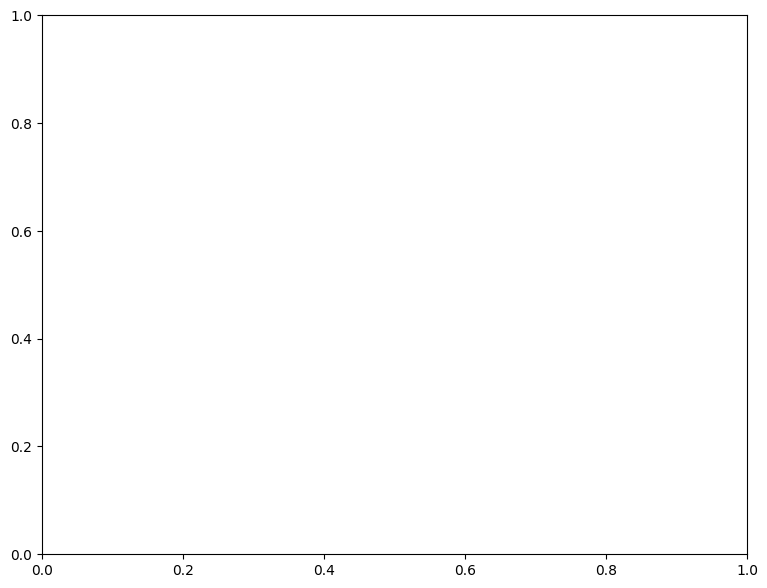

In [8]:
trainer.fit(model, train, val)

In [ ]:
seq_to_restore = '<EVQLVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCAKVKFYDPTAPNDYWGQGTLVTVSS>|'

In [ ]:
tokenizer1.aa_to_token

In [ ]:
model1 = model.ablang
tokenizer1 = model.tokenizer

with torch.no_grad():
    tokenPreds = model1(tokenizer1([seq_to_restore], pad=True, w_extra_tkns=False, device='cpu'))

tokenMAX = torch.max(torch.nn.Softmax(dim=-1)(tokenPreds), -1)

aaPreds = tokenizer1(tokenMAX.indices, mode='decode', device='cpu')

unkMatrix = torch.zeros(tokenMAX[0].shape, dtype=torch.long, device='cpu') + 21

aaPreds50 = ['-'.join(tokenizer1(torch.where(tokenMAX[0]<=.5, unkMatrix, tokenMAX[1]).detach(), mode='decode')[0].split('<unk>'))]

In [ ]:
tokenPreds[0][2]

In [ ]:
tokenMAX = torch.max(torch.nn.Softmax(dim=-1)(tokenPreds), -1)
tokenMAX[1]

In [ ]:
masked_to_restore = '***LVESGPGLVQPGKSLRLSCVASGFTFSGYGMHWVRQAPGKGLEWIALIIYDESNKYYADSVKGRFTISRDNSKNTLYLQMSSLRAEDTAVFYCAKVKFYDPTAPND************'
masked_to_restore = '<********************************GMHWVRQAPGKGLEWIALI*********ADSVKGRFTISRDNSKNTLYLQMSSLRA*********************************>|'

In [ ]:
with torch.no_grad():
    tokenPreds = model1(tokenizer1([masked_to_restore], pad=True, w_extra_tkns=False, device='cpu'))
    tokenMAX = torch.max(torch.nn.Softmax(dim=-1)(tokenPreds), -1)
    masked_aaPreds = tokenizer1(tokenMAX[1], mode='decode')
masked_aaPreds

In [ ]:
print(aaPreds[0])
print(aaPreds50[0])
print(seq_to_restore)